# American Bankruptcy Solution Notebook


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

# Step 1: Load the dataset
df = pd.read_csv('C:/Data/american_bankruptcy.csv')
df['year'] = round(df['year'].astype(int), 0)

# Step 2: Recode the 'status_label' so that only the last observation in a panel is 'failed'
# Sort the dataset by company_name and year to ensure the panel is correctly ordered
df = df.sort_values(by=['company_name', 'year'])

# Identify the last observation for each panel
df['is_last'] = df.groupby('company_name')['year'].transform('max') == df['year']

# Recode 'status_label' based on whether it's the last observation
# df['status_label'] = df.apply(lambda row: 'failed' if row['is_last'] else 'alive', axis=1)

df['status_label_2'] = 'alive'
df.loc[(df['is_last']) & (df['status_label'] == 'failed'), 'status_label_2'] = 'failed'

# Step 3: Convert 'status_label' into a boolean called 'bankrupt'
df['bankrupt'] = df['status_label_2'].map({'alive': 0, 'failed': 1})

# Drop the 'is_last' and 'status_label' columns if no longer needed
df = df.drop(columns=['is_last', 'status_label', 'status_label_2'])

I noticed here that some of you re-coded the data by
- keeping the bankrupt variable as 1 if a company ever becomes bankrupt
- limiting the timeframe analyzed.

These could be useful or not-so-useful manipulations. If you keep the bankrupt variable as one throughout, you change the nature of the prediction from 'the company will go bankrupt next year' to 'the company will eventually go bankrupt.' A better thing here would be a compromise where the variable turns to 1 for the last two years before bankruptcy - mainly since the Altman Z score was supposed to be predictive two years in advance. Such an approach would have reduced the imbalance in the data a bit.

Some of you tried to standardize the timeframe to keep only companies in the dataset that are present throughout. This is not a bad idea in principle, but it has a severe disadvantage here - the only bankrupt companies left in the dataset are those that went bankrupt in the last year. This creates even more imbalance in the data and a survival bias. A better approach is to focus on, e.g., companies that have more than five years of data or fix the time frame but ensure that all companies that went bankrupt during that timeframe stay in the dataset.

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 78682 entries, 0 to 11925
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company_name  78682 non-null  object 
 1   year          78682 non-null  int32  
 2   X1            78682 non-null  float64
 3   X2            78682 non-null  float64
 4   X3            78682 non-null  float64
 5   X4            78682 non-null  float64
 6   X5            78682 non-null  float64
 7   X6            78682 non-null  float64
 8   X7            78682 non-null  float64
 9   X8            78682 non-null  float64
 10  X9            78682 non-null  float64
 11  X10           78682 non-null  float64
 12  X11           78682 non-null  float64
 13  X12           78682 non-null  float64
 14  X13           78682 non-null  float64
 15  X14           78682 non-null  float64
 16  X15           78682 non-null  float64
 17  X16           78682 non-null  float64
 18  X17           78682 non-null  f

In [42]:
bankruptcy_count_by_year = df[df['bankrupt'] == 1].groupby('year').size()
print(bankruptcy_count_by_year)

year
1999     3
2000     7
2001    10
2002    17
2003    29
2004    46
2005    40
2006    51
2007    59
2008    58
2009    23
2010    35
2011    25
2012    26
2013    28
2014    33
2015    33
2016    29
2017    21
2018    36
dtype: int64


In [2]:
df.set_index(['company_name', 'year'], inplace=True)

In [8]:
company_bankruptcy = df.groupby('company_name')['bankrupt'].max()
percentage_bankruptcy = (company_bankruptcy.sum() / len(company_bankruptcy)) * 100
print(f"Percentage of companies that turned bankrupt: {percentage_bankruptcy:.2f}%")

Percentage of companies that turned bankrupt: 6.79%


This was a critical realization upfront: Not many companies go bankrupt!

The result is a severe imbalance in your data.

The first implication is not to focus too much on accuracy. You are 93% accurate with a method that predicts that no one goes bankrupt. Precision and recall were more essential measures in this context.

To figure out how to deal with imbalanced data, just enter "What classification method works with imbalanced data?" into any AI. You will see that Logistic Regression appears. Following up with 'How do I use Logistic Regression with imbalanced data?', you will see that you need the class_weight='balanced' option. You can also use a resampling technique called SMOTE. Further, you can adjust the decision threshold. All three of these help you get a better grip on the data.

Another implication was that QDA was not a great option, since QDA requires estimating a distribution for each class of the data, and with imbalance, there is not a whole lot of data in one of the classes.

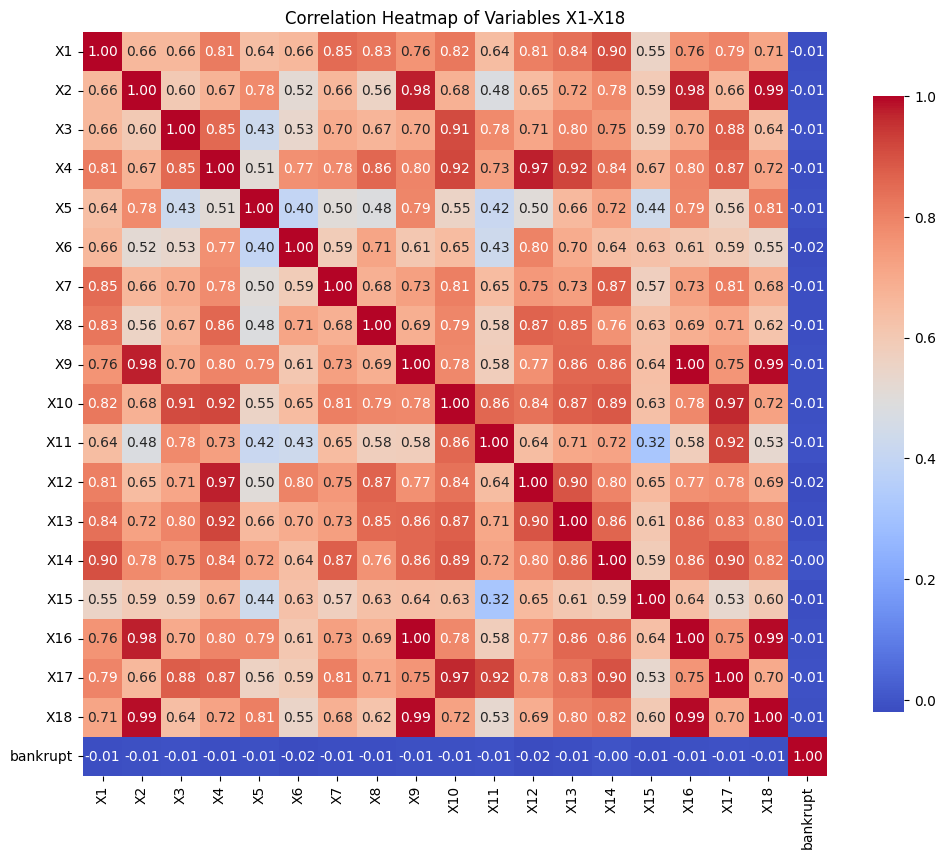

In [3]:
# Calculate the correlation matrix
corr_matrix = df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 
                  'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'bankrupt']].corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'shrink': .8})

# Customize the plot
plt.title('Correlation Heatmap of Variables X1-X18')
plt.show()

Here we calculate the Ratios underlying the Altman Z-Score

In [3]:
X_altman = pd.DataFrame(dtype=float)
X_altman["A1"] = (df["X1"] - df["X14"]) / (df["X10"])
X_altman["A2"] = df["X15"] / df["X10"]
X_altman["A3"] = df["X12"] / df["X10"]
X_altman["A4"]  = df["X8"] / df["X17"]
X_altman["A5"] = df["X9"] / df["X10"]
y = df['bankrupt']

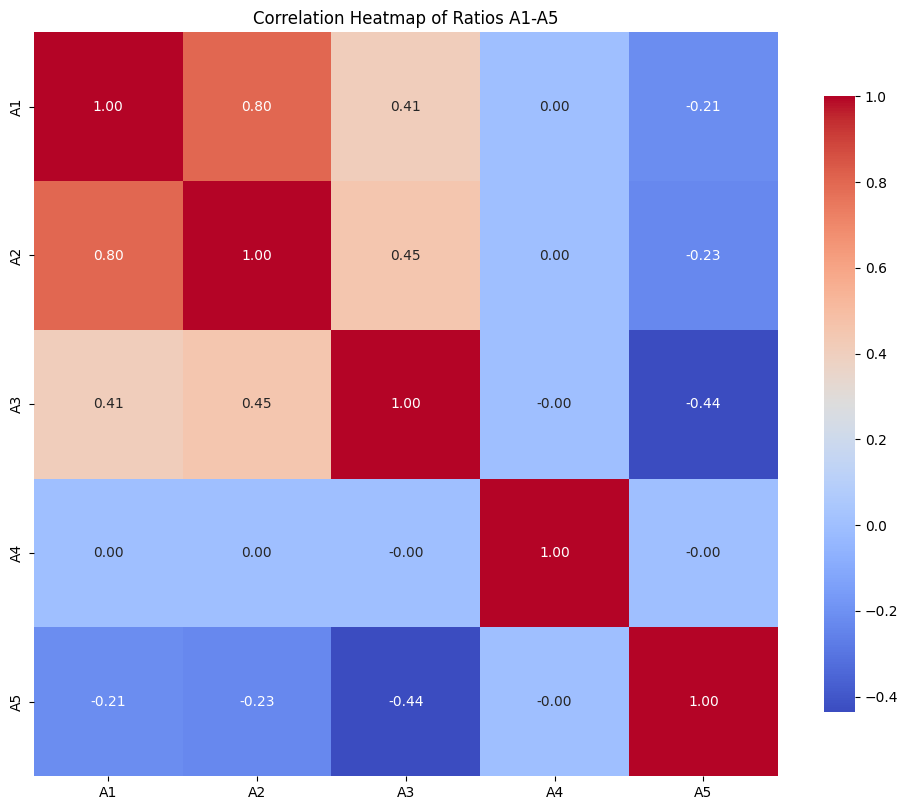

In [6]:
# Calculate the correlation matrix
corr_matrix = X_altman[['A1', 'A2', 'A3', 'A4', 'A5']].corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'shrink': .8})

# Customize the plot
plt.title('Correlation Heatmap of Ratios A1-A5')
plt.show()

In [5]:
X_altman["Z"] = 1.2 * X_altman["A1"] + 1.4 * X_altman["A2"] + 3.3 * X_altman["A3"] + 0.6 * X_altman["A4"] + 0.99 * X_altman["A5"]

Above is the calculation for the Altman Z-Score. It was essential to realize that the Altman Z-score is itself a model one can use for prediction. I examine the accuracy, precision and recall of this model below. Some of you made the error here of directly feeding the z-score into a new model to come up with a prediction; some of you used the altman predictions as a dependent variable. The simplest thing to do here is to just compare the actual bankruptcies (a vector or 0 and 1s) to the Altman Z-score predictions (a vector of 0s and 1s).

In [6]:
y_pred_altman = (X_altman["Z"] < 1.81).astype(int)
altman_accuracy = accuracy_score(y, y_pred_altman)
altman_precision = precision_score(y, y_pred_altman)
altman_recall = recall_score(y, y_pred_altman)
print(f'Altman Accuracy: {altman_accuracy:.2f}')
print(f'Altman Precision: {altman_precision:.2f}')
print(f'Altman Recall: {altman_recall:.2f}')

Altman Accuracy: 0.64
Altman Precision: 0.02
Altman Recall: 0.81


The Altman Z-Score has different zones, which are akin to different thresholds. You can evaluate how the Z-score does at a different threshold.

In [27]:
y_pred_altman = (X_altman["Z"] < 2.99).astype(int)
altman_accuracy = accuracy_score(y, y_pred_altman)
altman_precision = precision_score(y, y_pred_altman)
altman_recall = recall_score(y, y_pred_altman)
print(f'Altman Accuracy: {altman_accuracy:.2f}')
print(f'Altman Precision: {altman_precision:.2f}')
print(f'Altman Recall: {altman_recall:.2f}')

Altman Accuracy: 0.47
Altman Precision: 0.01
Altman Recall: 0.90


We can now train a new model. I use a logit model below. Notice the class_weight option due to the imbalance in the data. I use the ratios of the Altman Z-Scores as X variables - this would have been a good opportunity to expand the selection with additional variables. Many of you found useful ratios for prediction.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_altman, y, test_size=0.3, random_state=42)

logit = LogisticRegression(max_iter=4000, class_weight='balanced')
logit.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=4000)

In [5]:
y_pred_logit = logit.predict(X_test)

logit_accuracy = accuracy_score(y_test, y_pred_logit)
logit_precision = precision_score(y_test, y_pred_logit)
logit_recall = recall_score(y_test, y_pred_logit)
print(f'Logit Accuracy: {logit_accuracy:.2f}')
print(f'Logit Precision: {logit_precision:.2f}')
print(f'Logit Recall: {logit_recall:.2f}')

Logit Accuracy: 0.43
Logit Precision: 0.01
Logit Recall: 0.92


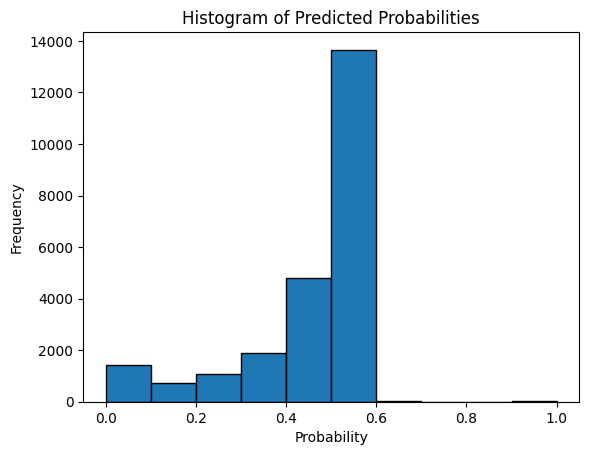

In [6]:
proba_logit = logit.predict_proba(X_test)[:, 1]

# Plotting the histogram
plt.hist(proba_logit, bins=10, edgecolor='black')

# Adding labels and title
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')

# Show plot
plt.show()

I experiment with setting different thresholds here.

In [16]:
y_pred_custom = (proba_logit >= 0.45).astype(int)

logit_accuracy = accuracy_score(y_test, y_pred_custom)
logit_precision = precision_score(y_test, y_pred_custom)
logit_recall = recall_score(y_test, y_pred_custom)
print(f'Logit Accuracy: {logit_accuracy:.2f}')
print(f'Logit Precision: {logit_precision:.2f}')
print(f'Logit Recall: {logit_recall:.2f}')

Logit Accuracy: 0.30
Logit Precision: 0.01
Logit Recall: 0.95


What was left to do is to examine how any of these models work pre, during and after the financial crisis, by examining precision and recall at different time periods.